# The goal here is to benchmark the DpoDetection tool with other depolymerase detection tools 
***
# I. Load the models :
#### 77 phages candidates 
>Detected Dpos <br>
>Missed Dpos <br>
***
# II. Getting the resulting predictions
#### Pires Dpos

***
# III. Make figures
***

I.
> Make the predictions : DpoDetection Tool :

In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/DepoDetection.S1.conv.model \
/media/concha-eloko/Linux/depolymerase_building

In [1]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch
from torch import nn 
import torch.nn.functional as F

import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pandas as pd 

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

path_work = "/media/concha-eloko/Linux/depolymerase_building"

# Load model :
esm2_model_path = f"{path_work}/esm2_t12_35M_UR50D__fulltrain__finetuneddepolymerase.2103.4_labels/checkpoint-2255"
DpoDetection_path = f"{path_work}/Deposcope.esm2_t12_35M_UR50D.2203.full.model"

tokenizer = AutoTokenizer.from_pretrained(esm2_model_path)
esm2_finetuned = AutoModelForTokenClassification.from_pretrained(esm2_model_path)


/media/concha-eloko/Linux/conda_envs/ML_work/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Dpo_classifier(nn.Module):
    def __init__(self, pretrained_model):
        super(Dpo_classifier, self).__init__()
        self.max_length = 1024
        self.pretrained_model = pretrained_model
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=1)  # Convolutional layer
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1)  # Convolutional layer
        self.fc1 = nn.Linear(128 * (self.max_length - 2 * (5 - 1)), 32)  # calculate the output shape after 2 conv layers
        self.classifier = nn.Linear(32, 1)  # Binary classification

    def make_prediction(self, fasta_txt):
        input_ids = tokenizer.encode(fasta_txt, truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = self.pretrained_model(input_ids)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            token_probs, token_ids = torch.max(probs, dim=-1)            
            tokens = token_ids.view(1, -1) # ensure 2D shape
            return tokens

    def pad_or_truncate(self, tokens):
        if tokens.size(1) < self.max_length:
            tokens = F.pad(tokens, (0, self.max_length - tokens.size(1)))
        elif tokens.size(1) > self.max_length:
            tokens = tokens[:, :self.max_length]
        return tokens

    def forward(self, sequences):
        batch_size = len(sequences)
        tokens_batch = []
        for seq in sequences:
            tokens = self.make_prediction(seq)
            tokens = self.pad_or_truncate(tokens)
            tokens_batch.append(tokens)
        
        outputs = torch.cat(tokens_batch).view(batch_size, 1, self.max_length)  # ensure 3D shape
        outputs = outputs.float()  # Convert to float
        
        out = F.relu(self.conv1(outputs))
        out = F.relu(self.conv2(out))
        out = out.view(batch_size, -1)  # Flatten the tensor
        out = F.relu(self.fc1(out))
        out = self.classifier(out)
        return out, outputs


In [3]:
model_classifier = Dpo_classifier(esm2_finetuned) # Create an instance of Dpo_classifier
model_classifier.load_state_dict(torch.load(DpoDetection_path), strict = False) # Load the saved weights ; weird Error with some of the keys 
model_classifier.eval() # Set the model to evaluation mode for inference


Dpo_classifier(
  (pretrained_model): EsmForTokenClassification(
    (esm): EsmModel(
      (embeddings): EsmEmbeddings(
        (word_embeddings): Embedding(33, 480, padding_idx=1)
        (dropout): Dropout(p=0.0, inplace=False)
        (position_embeddings): Embedding(1026, 480, padding_idx=1)
      )
      (encoder): EsmEncoder(
        (layer): ModuleList(
          (0-11): 12 x EsmLayer(
            (attention): EsmAttention(
              (self): EsmSelfAttention(
                (query): Linear(in_features=480, out_features=480, bias=True)
                (key): Linear(in_features=480, out_features=480, bias=True)
                (value): Linear(in_features=480, out_features=480, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (rotary_embeddings): RotaryEmbedding()
              )
              (output): EsmSelfOutput(
                (dense): Linear(in_features=480, out_features=480, bias=True)
                (dropout): Dropout(p=0.0, inpla

In [4]:
def predict_sequence(model, sequence):
    model.eval()
    with torch.no_grad():
        sequence = [sequence]  # Wrap the sequence in a list to match the model's input format
        outputs, sequence_outputs = model(sequence)
        probas = torch.sigmoid(outputs)  # Apply sigmoid activation for binary classification
        predictions = (probas > 0.5).float()  # Convert probabilities to binary predictions
        sequence_outputs_list = sequence_outputs.cpu().numpy().tolist()[0][0]
        prob_predicted = probas[0].item()
        return (predictions.item(), prob_predicted), sequence_outputs_list


def plot_token(tokens) :
    tokens = np.array(tokens)  # convert your list to numpy array for convenience
    plt.figure(figsize=(10,6))
    for i in range(len(tokens) - 1):
        if tokens[i] == 0:
            color = 'black'
        elif tokens[i] == 1:
            color = 'blue'
        elif tokens[i] == 2:
            color = 'red'
        else :
            color = 'green'
        plt.plot([i, i+1], [tokens[i], tokens[i+1]], color=color, marker='o')
    plt.xlabel('Token')
    plt.ylabel('Label')
    plt.title('Label for each token')
    plt.xticks(rotation='vertical')
    plt.yticks(np.arange(2), ['0', '1'])  
    plt.grid(True)
    plt.show()

In [5]:
input_fasta = "MGLHVQKSQLSVIKLGDYGAVGDGVTDDTTSFINLEAEHKGKIINLEFKTYLVDKGFSGNFYINGSFKVGDNTFAAPYTLPYANNSNIFMGENSGVNTDKYPVYMASAGGYSNIGIGKNALKSNTEGWRNVAIGDGALVNNTLGHYNIAVGDEALRDNIGSRNGDSTDNGSRNTAVGSNTMCYNTTGYCNTAMGRNALHTNFTGYHNTAIGAAALSGNAPYVNGVVVPDDPKHGNYNTAVGSEALFRGNSDHNTAVGRSAAWNTKNGARNVAIGSEALYYNEANVTYDDKTTAGAGNTAVGTAAMKYMQDGSQATLVNNSSAIGYGARVSGDNQVQLGGSGTTTYSYGAVQSRSDQRDKTDIKDTELGLDFLLKVRPVDFRWDYRDDYQEIDEEGNLITHEKDGSRSGNRFHHGVIAQEIQEVIQKTGKDFGGLQDHKINGGTDVLSIGYEEFIAPIIKSIHELHKMVSDLSDRISELENK"

prediction , token = predict_sequence(model_classifier ,input_fasta)

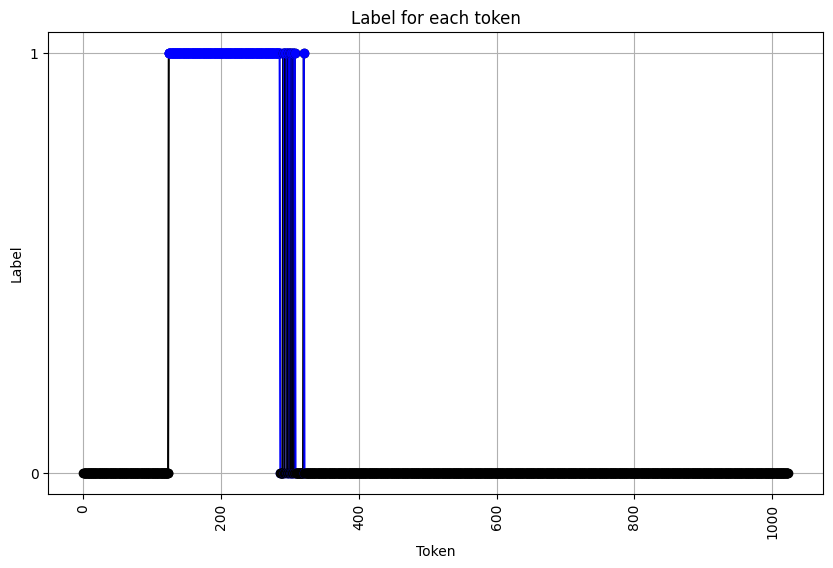

((1.0, 0.9799231886863708), None)

In [6]:
prediction  , plot_token(token)

***
# VS Pires 2016

In [7]:
class Dpo_model_pred:
    def __init__(self, name, tokens, prediction, sequence):
        self.name = name
        self.tokens = tokens
        self.prediction = prediction
        self.sequence = sequence
        
    def plot_token(self) :
        tokens = np.array(self.tokens)  
        plt.figure(figsize=(10,6))
        for i in range(len(tokens) - 1):
            if tokens[i] == 0:
                color = 'black'
            elif tokens[i] == 1:
                color = 'blue'
            elif tokens[i] == 2:
                color = 'red'
            else:
                color = 'green'
            plt.plot([i, i+1], [tokens[i], tokens[i+1]], color=color, marker='o')
        plt.xlabel('Token')
        plt.ylabel('Label')
        plt.title('Label for each token')
        plt.xticks(rotation='vertical')
        plt.yticks(np.arange(2), ['0', '1'])  
        plt.grid(True)
        plt.show()

    def get_prediction(self):
        return self.prediction
    
    def get_seq(self):
        return self.sequence



> Get the other tools results

Make the predictions 

In [ ]:
rsync -avzhe ssh \
/media/concha-eloko/Linux/PhageDEPOdetection/data_Benchmarking/benchmark_dataframe.csv \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb \


In [8]:
import pandas as pd 
import os 
from tqdm import tqdm
from Bio import SeqIO

path_DePP_results = "/media/concha-eloko/Linux/PhageDEPOdetection/data_Benchmarking"
df_results = pd.read_csv(f"{path_DePP_results}/benchmark_dataframe.csv", header = 0 )


In [9]:
seq_to_remove = SeqIO.parse(f"{path_DePP_results}/remove_benchmark.fasta", "fasta")
seq_to_remove_list = [record.seq for record in seq_to_remove]

In [38]:
df_final_results = pd.read_csv(f"{path_DePP_results}/full_benchmark_dataframe.4L.2008.csv", header = 0, sep = ",")
df_final_results = df_final_results[df_final_results["protein_seq"].str.len() >= 200]
df_final_results_unseen = df_final_results[~df_final_results["protein_seq"].isin(seq_to_remove_list)]
df_final_results_unseen.reset_index(inplace = True)
df_final_results_unseen.drop(["index"], axis = 1, inplace = True)

/tmp/ipykernel_93192/1051509681.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_results_unseen.drop(["index"], axis = 1, inplace = True)


In [41]:
df_final_results_unseen

,genome_id,protein_id,dna_seq,protein_seq,label,scores_phageDPO,scores_DePP,scores_DepolyX,score_Deposcope
0,KC821630.1,AGO49320,ATGGCTTTACATACTAGAAAAGAGTTCGCTGCTCTATGCAGAACAA...,MALHTRKEFAALCRTTIAVVNTNVNRNKIQLHDKKIDSQNAINKKF...,0,0.0,0.243067,0.019835,0.000327
1,KC821630.1,AGO49323,ATGAATTTAAAAGATATTTGGAAACAGCAGTTAAATTTTTTCAATT...,MNLKDIWKQQLNFFNSKLYSYKTIKAIPSEWVEKTIILDPEVSRFS...,0,21.0,0.852377,0.019835,0.000327
2,KC821630.1,AGO49325,ATGAGTTTTAAAGAAAATTGGAATAAGTTTACTGAAGTTTTCTTAG...,MSFKENWNKFTEVFLGKETQQASSSSPYYNEANDGRSYNPIIDDLF...,0,32.0,0.799602,0.019835,0.000327
3,KC821630.1,AGO49327,ATGAAAAATTATTTGTCAATTTTATTTTTGCTTTCAAGCTTTTTAG...,MKNYLSILFLLSSFLVLSQNPTSFRNGVIPGVKTTAEIQAIVSPKL...,0,82.0,0.764837,0.019835,0.000327
4,KC821630.1,AGO49330,ATGAATTTTCCCCGAATCAAGAGCTTTATCAAAAAGTCGAATTATA...,MNFPRIKSFIKKSNYKRRILLVRLRCVKRLIRQKIWIRKIIRSKVL...,0,2.0,0.277224,0.019835,0.000327
...,...,...,...,...,...,...,...,...,...
5455,NC_048631.1,YP_009829900,ATGAGAATGAAAAAGATTCTTTTAATTTGTGTTCCCTTCGTAATTT...,MRMKKILLICVPFVILAVAASLYFFNKDQNKQTSAVTDDEKYNDEQ...,0,8.0,0.516787,0.019835,0.000327
5456,NC_048631.1,YP_009829902,ATGCTAGAATATTGTTTGAGAAAATTTAGAATATTTGTAGAAAGAG...,MLEYCLRKFRIFVERGVYLMSKLASECVANILNDWYIAIKQQDAES...,0,0.0,0.386534,0.019835,0.000327
5457,NC_048631.1,YP_009829903,ATGAACTTGATGGATGAAAACACTCCAAAGAATGTCGGGATATACG...,MNLMDENTPKNVGIYVRVSTEEQAKEGYSISAQKEKLKAYCISQGW...,0,1.0,0.524053,0.019835,0.000327
5458,NC_048631.1,YP_009829911,ATGTTTCAAGTAACAGACGCGCAACGTCAAAAGGAAAAAGCAATTG...,MFQVTDAQRQKEKAIVGFIGPSGSGKTAGALLVAYGMMQEAYPDAS...,0,1.0,0.384229,0.019835,0.000327


In [40]:
df_final_results_unseen["score_Deposcope"] = [num[1] for num in output_label_Deposcope]

/tmp/ipykernel_93192/2710970956.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_results_unseen["score_Deposcope"] = [num[1] for num in output_label_Deposcope]


In [12]:
%%time
output_label_Deposcope = []

all_lengths = 0
for seq in tqdm(df_final_results_unseen["protein_seq"]) : 
    prediction, sequence_outputs = predict_sequence(model_classifier, seq)
    output_label_Deposcope.append(prediction)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5460/5460 [44:32<00:00,  2.04it/s]

CPU times: user 2h 39min 2s, sys: 17min 42s, total: 2h 56min 45s
Wall time: 44min 32s


In [34]:
df_final_results_unseen

,genome_id,protein_id,dna_seq,protein_seq,label,scores_phageDPO,scores_DePP,scores_DepolyX,scores_Deposcope,score_Deposcope
0,KC821630.1,AGO49320,ATGGCTTTACATACTAGAAAAGAGTTCGCTGCTCTATGCAGAACAA...,MALHTRKEFAALCRTTIAVVNTNVNRNKIQLHDKKIDSQNAINKKF...,0,0.0,0.243067,0.019835,"(0.0, 0.00032747030491009355)",0.000327
1,KC821630.1,AGO49323,ATGAATTTAAAAGATATTTGGAAACAGCAGTTAAATTTTTTCAATT...,MNLKDIWKQQLNFFNSKLYSYKTIKAIPSEWVEKTIILDPEVSRFS...,0,21.0,0.852377,0.019835,"(0.0, 0.00032747030491009355)",0.000327
2,KC821630.1,AGO49325,ATGAGTTTTAAAGAAAATTGGAATAAGTTTACTGAAGTTTTCTTAG...,MSFKENWNKFTEVFLGKETQQASSSSPYYNEANDGRSYNPIIDDLF...,0,32.0,0.799602,0.019835,"(0.0, 0.00032747030491009355)",0.000327
3,KC821630.1,AGO49327,ATGAAAAATTATTTGTCAATTTTATTTTTGCTTTCAAGCTTTTTAG...,MKNYLSILFLLSSFLVLSQNPTSFRNGVIPGVKTTAEIQAIVSPKL...,0,82.0,0.764837,0.019835,"(0.0, 0.00032747030491009355)",0.000327
4,KC821630.1,AGO49330,ATGAATTTTCCCCGAATCAAGAGCTTTATCAAAAAGTCGAATTATA...,MNFPRIKSFIKKSNYKRRILLVRLRCVKRLIRQKIWIRKIIRSKVL...,0,2.0,0.277224,0.019835,"(0.0, 0.00032747030491009355)",0.000327
...,...,...,...,...,...,...,...,...,...,...
5455,NC_048631.1,YP_009829900,ATGAGAATGAAAAAGATTCTTTTAATTTGTGTTCCCTTCGTAATTT...,MRMKKILLICVPFVILAVAASLYFFNKDQNKQTSAVTDDEKYNDEQ...,0,8.0,0.516787,0.019835,"(0.0, 0.00032747030491009355)",0.000327
5456,NC_048631.1,YP_009829902,ATGCTAGAATATTGTTTGAGAAAATTTAGAATATTTGTAGAAAGAG...,MLEYCLRKFRIFVERGVYLMSKLASECVANILNDWYIAIKQQDAES...,0,0.0,0.386534,0.019835,"(0.0, 0.00032747030491009355)",0.000327
5457,NC_048631.1,YP_009829903,ATGAACTTGATGGATGAAAACACTCCAAAGAATGTCGGGATATACG...,MNLMDENTPKNVGIYVRVSTEEQAKEGYSISAQKEKLKAYCISQGW...,0,1.0,0.524053,0.019835,"(0.0, 0.00032747030491009355)",0.000327
5458,NC_048631.1,YP_009829911,ATGTTTCAAGTAACAGACGCGCAACGTCAAAAGGAAAAAGCAATTG...,MFQVTDAQRQKEKAIVGFIGPSGSGKTAGALLVAYGMMQEAYPDAS...,0,1.0,0.384229,0.019835,"(0.0, 0.00032747030491009355)",0.000327


In [42]:
df_final_results_unseen.to_csv(f"{path_DePP_results}/full_benchmark_dataframe.4L.230324.csv", sep = ",", index = False)


In [4]:
#scores_DepolyX = [pred[1] for _,pred in enumerate(output_label_DepolyX)]
#df_results["scores_DepolyX"] = scores_DepolyX
#df_results.to_csv(f"{path_DePP_results}/full_benchmark_dataframe.3L.2008.csv", sep = ",", index = False)

import pandas as pd 
import os 
from tqdm import tqdm
from Bio import SeqIO

path_work = "/media/concha-eloko/Linux/PhageDEPOdetection/data_Benchmarking"

df_final_results = pd.read_csv(f"{path_work}/full_benchmark_dataframe.4L.230324.csv", header = 0, sep = ",")
df_final_results


,genome_id,protein_id,dna_seq,protein_seq,label,scores_phageDPO,scores_DePP,scores_DepolyX,score_Deposcope
0,KC821630.1,AGO49320,ATGGCTTTACATACTAGAAAAGAGTTCGCTGCTCTATGCAGAACAA...,MALHTRKEFAALCRTTIAVVNTNVNRNKIQLHDKKIDSQNAINKKF...,0,0.0,0.243067,0.019835,0.000327
1,KC821630.1,AGO49323,ATGAATTTAAAAGATATTTGGAAACAGCAGTTAAATTTTTTCAATT...,MNLKDIWKQQLNFFNSKLYSYKTIKAIPSEWVEKTIILDPEVSRFS...,0,21.0,0.852377,0.019835,0.000327
2,KC821630.1,AGO49325,ATGAGTTTTAAAGAAAATTGGAATAAGTTTACTGAAGTTTTCTTAG...,MSFKENWNKFTEVFLGKETQQASSSSPYYNEANDGRSYNPIIDDLF...,0,32.0,0.799602,0.019835,0.000327
3,KC821630.1,AGO49327,ATGAAAAATTATTTGTCAATTTTATTTTTGCTTTCAAGCTTTTTAG...,MKNYLSILFLLSSFLVLSQNPTSFRNGVIPGVKTTAEIQAIVSPKL...,0,82.0,0.764837,0.019835,0.000327
4,KC821630.1,AGO49330,ATGAATTTTCCCCGAATCAAGAGCTTTATCAAAAAGTCGAATTATA...,MNFPRIKSFIKKSNYKRRILLVRLRCVKRLIRQKIWIRKIIRSKVL...,0,2.0,0.277224,0.019835,0.000327
...,...,...,...,...,...,...,...,...,...
5455,NC_048631.1,YP_009829900,ATGAGAATGAAAAAGATTCTTTTAATTTGTGTTCCCTTCGTAATTT...,MRMKKILLICVPFVILAVAASLYFFNKDQNKQTSAVTDDEKYNDEQ...,0,8.0,0.516787,0.019835,0.000327
5456,NC_048631.1,YP_009829902,ATGCTAGAATATTGTTTGAGAAAATTTAGAATATTTGTAGAAAGAG...,MLEYCLRKFRIFVERGVYLMSKLASECVANILNDWYIAIKQQDAES...,0,0.0,0.386534,0.019835,0.000327
5457,NC_048631.1,YP_009829903,ATGAACTTGATGGATGAAAACACTCCAAAGAATGTCGGGATATACG...,MNLMDENTPKNVGIYVRVSTEEQAKEGYSISAQKEKLKAYCISQGW...,0,1.0,0.524053,0.019835,0.000327
5458,NC_048631.1,YP_009829911,ATGTTTCAAGTAACAGACGCGCAACGTCAAAAGGAAAAAGCAATTG...,MFQVTDAQRQKEKAIVGFIGPSGSGKTAGALLVAYGMMQEAYPDAS...,0,1.0,0.384229,0.019835,0.000327


In [5]:
genomes_id = df_final_results["genome_id"].unique().tolist()

def get_metrics(df, tool_score , threshold) : 
    tp , tn , fp , fn = 0 , 0 , 0 , 0
    for _,row in df.iterrows() : 
        if row["label"] == 0 : 
            if row[tool_score] >= threshold : 
                fp += 1 
            else :
                tn += 1 
        else :
            if row[tool_score] >= threshold : 
                tp += 1 
            else :
                fn += 1 
    return [tp , tn , fp , fn]
    
metrics = {}
for _,genome in enumerate(genomes_id) :  
    #df_genome = df_results[(df_results["genome_id"] == genome) & (len(df_results["protein_seq"]) >= 200)]
    df_genome = df_final_results[(df_final_results["genome_id"] == genome)]
    metric_phageDPO = get_metrics(df_genome , "scores_phageDPO" , 50)
    metric_DePP = get_metrics(df_genome , "scores_DePP" , 0.5)
    metric_DepolyX = get_metrics(df_genome , "scores_DepolyX" , 0.5)
    metric_Deposcope = get_metrics(df_genome , "score_Deposcope" , 0.5)
    a = {"phageDPO" : metric_phageDPO , "DePP" : metric_DePP, "DepolyX" : metric_DepolyX, "Deposcope" : metric_Deposcope}
    metrics[genome] = a

In [8]:
import json
import pprint
pp = pprint.PrettyPrinter(width = 100, sort_dicts = True, compact = True)
pp.pprint(metrics)

{'AY349011.3': {'DePP': [1, 21, 5, 0],
                'DepolyX': [1, 24, 2, 0],
                'Deposcope': [1, 25, 1, 0],
                'phageDPO': [1, 24, 2, 0]},
 'CP000711.1': {'DePP': [0, 13, 5, 0],
                'DepolyX': [0, 18, 0, 0],
                'Deposcope': [0, 17, 1, 0],
                'phageDPO': [0, 17, 1, 0]},
 'DQ831957.1': {'DePP': [0, 10, 9, 0],
                'DepolyX': [0, 19, 0, 0],
                'Deposcope': [0, 19, 0, 0],
                'phageDPO': [0, 13, 6, 0]},
 'DQ834250.1': {'DePP': [1, 11, 8, 0],
                'DepolyX': [1, 19, 0, 0],
                'Deposcope': [1, 19, 0, 0],
                'phageDPO': [1, 14, 5, 0]},
 'FQ482084.1': {'DePP': [1, 10, 10, 0],
                'DepolyX': [1, 19, 1, 0],
                'Deposcope': [1, 19, 1, 0],
                'phageDPO': [1, 18, 2, 0]},
 'FR671405.1': {'DePP': [1, 5, 5, 0],
                'DepolyX': [0, 10, 0, 1],
                'Deposcope': [0, 10, 0, 1],
                'phageDPO': [0

In [9]:
from collections import Counter 
Counter(df_final_results["label"])

Counter({0: 5377, 1: 83})

In [6]:
data_dict = {"Deposcope_v0" : df_final_results["scores_DepolyX"], 
             "Deposcope_real" : df_final_results["score_Deposcope"], 
             "PhageDPO" : (df_final_results["scores_phageDPO"]/100), 
             "DePP" : df_final_results["scores_DePP"], 
             "Label" : df_final_results["label"]}

data_color = {"Deposcope_v0" : "#b22234", 
              "Deposcope_real": "#000000" ,
             "PhageDPO" : "#3c3b6e", 
             "DePP" : "#828282"}

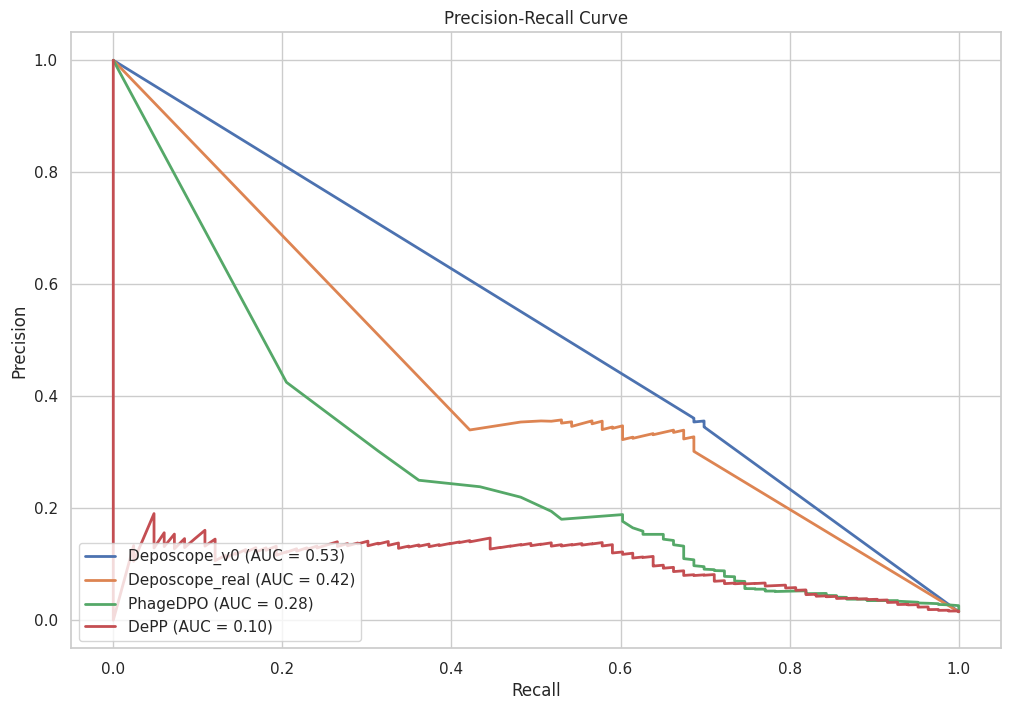

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc

def plot_multiple_precision_recall_curves(data_dict):
    plt.figure(figsize=(12, 8))
    lw = 2
    sns.set(style="whitegrid")
    for key, value in data_dict.items():
        if key != "Label":
            precision, recall, _ = precision_recall_curve(data_dict["Label"], value)
            pr_auc = auc(recall, precision)
            plt.plot(recall, precision, lw=lw, label=f'{key} (AUC = {pr_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.savefig('/media/concha-eloko/Linux/papers/Deposcope/Precision_Recall_methods.2303.png', dpi=500)
    plt.show()

plot_multiple_precision_recall_curves(data_dict)

In [5]:
full_metric = {}

metric_phageDPO = get_metrics(df_final_results , "scores_phageDPO" , 50)
metric_DePP = get_metrics(df_final_results , "scores_DePP" , 0.5)
metric_DepolyX = get_metrics(df_final_results , "scores_DepolyX" , 0.5)
metric_Deposcope = get_metrics(df_final_results , "score_Deposcope" , 0.5)

full_metric = {"DePP" : metric_DePP, "phageDPO" : metric_phageDPO , "DepolyX" : metric_DepolyX, "Deposcope" : metric_Deposcope}
full_metric

{'DePP': [76, 3275, 2102, 7],
 'phageDPO': [62, 4412, 965, 21],
 'DepolyX': [58, 5270, 107, 25],
 'Deposcope': [57, 5254, 123, 26]}

In [16]:
full_metric_unseen = {'DePP': [76, 3275, 2102, 7],
 'phageDPO': [62, 4412, 965, 21],
 'DepolyX': [58, 5270, 107, 25],
 'Deposcope': [57, 5254, 13, 26]}

In [17]:
df_metric_1 = pd.DataFrame(metrics)
df_metric_1

,KC821630.1,NC_019454.1,NC_020842.1,NC_019917.1,NC_021856.1,FR671410.1,FR671406.1,NC_009819.1,NC_017980.1,KC556894.1,...,NC_020478.1,NC_009014.1,NC_024211.1,CP000711.1,NC_017981.1,NC_001423.1,NC_024137.1,NC_017972.1,NC_020078.1,NC_048631.1
phageDPO,"[0, 26, 6, 0]","[1, 16, 2, 0]","[0, 23, 6, 0]","[0, 27, 1, 0]","[0, 47, 11, 2]","[0, 11, 1, 1]","[0, 14, 1, 1]","[1, 15, 3, 0]","[0, 7, 2, 0]","[0, 19, 4, 0]",...,"[0, 18, 4, 0]","[1, 17, 2, 0]","[1, 52, 8, 0]","[0, 17, 1, 0]","[0, 19, 4, 0]","[0, 7, 3, 0]","[1, 67, 9, 0]","[0, 130, 20, 1]","[0, 17, 1, 0]","[0, 14, 1, 0]"
DePP,"[0, 17, 15, 0]","[1, 10, 8, 0]","[0, 15, 14, 0]","[0, 22, 6, 0]","[1, 35, 23, 1]","[1, 7, 5, 0]","[1, 8, 7, 0]","[0, 5, 13, 1]","[0, 5, 4, 0]","[0, 16, 7, 0]",...,"[0, 17, 5, 0]","[1, 9, 10, 0]","[1, 39, 21, 0]","[0, 13, 5, 0]","[0, 18, 5, 0]","[0, 4, 6, 0]","[1, 46, 30, 0]","[0, 105, 45, 1]","[0, 11, 7, 0]","[0, 6, 9, 0]"
DepolyX,"[0, 31, 1, 0]","[1, 17, 1, 0]","[0, 29, 0, 0]","[0, 27, 1, 0]","[1, 57, 1, 1]","[0, 12, 0, 1]","[0, 15, 0, 1]","[1, 18, 0, 0]","[0, 9, 0, 0]","[0, 22, 1, 0]",...,"[0, 22, 0, 0]","[1, 18, 1, 0]","[1, 60, 0, 0]","[0, 18, 0, 0]","[0, 23, 0, 0]","[0, 10, 0, 0]","[1, 76, 0, 0]","[0, 149, 1, 1]","[0, 17, 1, 0]","[0, 15, 0, 0]"
Deposcope,"[0, 31, 1, 0]","[1, 17, 1, 0]","[0, 28, 1, 0]","[0, 28, 0, 0]","[0, 56, 2, 2]","[0, 12, 0, 1]","[0, 15, 0, 1]","[1, 18, 0, 0]","[0, 9, 0, 0]","[0, 23, 0, 0]",...,"[0, 22, 0, 0]","[1, 18, 1, 0]","[1, 60, 0, 0]","[0, 17, 1, 0]","[0, 22, 1, 0]","[0, 10, 0, 0]","[1, 76, 0, 0]","[0, 147, 3, 1]","[0, 17, 1, 0]","[0, 15, 0, 0]"


In [18]:
def get_precision(metric) : 
    tp , tn , fp , fn = metric[0] , metric[1] , metric[2] , metric[3]
    return tp/(tp + fp)
    
def get_recall(metric) : 
    tp , tn , fp , fn = metric[0] , metric[1] , metric[2] , metric[3]
    return tp/(tp + fn)

def F1_score(metric) : 
    precision = get_precision(metric)
    recall = get_recall(metric)
    return 2*(precision*recall) / (precision + recall)

def accuracy_score(metric) : 
    tp , tn , fp , fn = metric[0] , metric[1] , metric[2] , metric[3]
    return (tp + tn)/(tp + tn + fp + fn)

def specificity_score(metric) :
    tp , tn , fp , fn = metric[0] , metric[1] , metric[2] , metric[3]
    return tn /(tn + fp)

def MCC(metric) : 
    tp , tn , fp , fn = metric[0] , metric[1] , metric[2] , metric[3]
    mcc = (tp*tn - fp*fn)/((tp+fp) * (tp+fn) * (tn+fp) * (tn+fn))**0.5
    return mcc

In [19]:
#print("precision\trecall\taccuracy\tf1\tMCC\tspecificity")
for tool in full_metric_unseen:
    print(tool)
    print(round(get_precision(full_metric_unseen[tool]), 4), 
          round(get_recall(full_metric_unseen[tool]), 4), 
          round(specificity_score(full_metric_unseen[tool]), 4), 
          round(accuracy_score(full_metric_unseen[tool]), 4), 
          round(F1_score(full_metric_unseen[tool]), 4), 
          round(MCC(full_metric_unseen[tool]), 4), 
          sep="\t")



DePP
0.0349	0.9157	0.6091	0.6137	0.0672	0.1311
phageDPO
0.0604	0.747	0.8205	0.8194	0.1117	0.1777
DepolyX
0.3515	0.6988	0.9801	0.9758	0.4677	0.4852
Deposcope
0.8143	0.6867	0.9975	0.9927	0.7451	0.7442


***

# Investigating the results : 

### The FPs :

In [2]:
import Bio.PDB

# define a dictionary to map three-letter amino acid codes to one-letter codes
aa_codes = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
    'GLU': 'E', 'GLN': 'Q', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
    'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
    'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V',
    'UNK': 'X'
}

def get_pdb_sequence(pdb_path):
    """
    Get the amino acid sequence from a PDB file.
    Parameters:
    pdb_path (str): The path to the PDB file.
    Returns:
    str: The amino acid sequence.
    """
    # parse the PDB file
    parser = Bio.PDB.PDBParser()
    structure = parser.get_structure('PDB', pdb_path)
    # extract the amino acid sequence
    sequence = ''
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_resname() in aa_codes:
                    sequence += aa_codes[residue.get_resname()]
                elif residue.get_resname() == 'UNK':
                    sequence += 'X'
    return sequence




In [3]:
import pandas as pd 
import os 
from tqdm import tqdm
from Bio import SeqIO

path_work = "/media/concha-eloko/Linux/PhageDEPOdetection/data_Benchmarking"
path_FPs = "/media/concha-eloko/Linux/PhageDEPOdetection/FP_2108"

FP_predicted = {}

for file in os.listdir(path_FPs) :
    seq = get_pdb_sequence(f"{path_FPs}/{file}")
    FP_predicted[seq] = f"{path_FPs}/{file}"
    #print(seq)

/media/concha-eloko/Linux/conda_envs/ML_work/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4973
  warnings.warn(
/media/concha-eloko/Linux/conda_envs/ML_work/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 7646
  warnings.warn(
/media/concha-eloko/Linux/conda_envs/ML_work/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3993
  warnings.warn(
/media/concha-eloko/Linux/conda_envs/ML_work/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5839
  warnings.warn(
/media/concha-eloko/Linux/conda_envs/ML_work/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6311
  warnings.warn(
/media/concha-eloko/Linux/conda_envs/ML_work/lib/python

In [10]:
len(FP_predicted)

138

In [15]:
path_fp_seq = "/media/concha-eloko/Linux/PhageDEPOdetection"
pdb_source = "/media/concha-eloko/Linux/PhageDEPOdetection/FP_2108"
pdb_destination = "/media/concha-eloko/Linux/PhageDEPOdetection/FP_2108_pt2"


deposcope_FP_sequences = []
deposcope_FP_predicted = []
deposcope_FP_unpredicted = []

deposcope_FN_sequences = []

for _,row in df_final_results.iterrows() : 
    a = (row["genome_id"], row["protein_id"], row["protein_seq"])
    if row["label"] == 0 and row["score_Deposcope"] > 0.5 : 
        deposcope_FP_sequences.append(row["protein_seq"])
        if row["protein_seq"] in FP_predicted :
            deposcope_FP_predicted.append(a)
        else :
            deposcope_FP_unpredicted.append(a)
    elif row["label"] == 1 and row["score_Deposcope"] < 0.5 :
        a = (row["genome_id"], row["protein_id"], row["protein_seq"])
        deposcope_FN_sequences.append(a)

In [16]:
len(deposcope_FP_unpredicted) , len(deposcope_FP_predicted), len(deposcope_FP_sequences)

(1, 122, 123)

In [18]:
deposcope_FP_predicted

[('KC821630.1',
  'AGO49349',
  'MRTIKNLALPQDSDYVNFPDGRVRNETVTAAGTPVVEEVYGDLLQNFYKIIRSSGLEITETADSEGTQFQLLDALKIFANEVNDLKQTLTVNQGEISTLLNLDTLPDDYVFIGKITEDISANNIYLLNGTGEVLVNAVSTSDVKASSLVLVVLSQVGYSSITDLTVAAEDLKSLSVSLGTPLSFNSTKNLMYFSDGKIITDYPKVYDVQQAINDSLMTSDFVAIDCFTVKEKLLCYAFNKTNSTYHLFSFLASNPGALEGEVTFIKSVNAAENKPLIYTNGQFLFITNTENEFGDIASHNKIGKYLFDEVALEITLDTSLTIESSFFKSTNCFINEAGSDIYSMLLGQLNKYSLENNTVEDLGNFQSNNGQVFRFNKQTYFYNGSNAAKWNY'),
 ('NC_019454.1',
  'YP_007002897',
  'MASSLEGAYKSLLQGVSQQVPRLRLDGQVSTQENMLADPVTSLRRRPGAPLTVIHSLGTITDTNLYTQYVERGSDGRTLIINTSTGNWWVMNKDATAVLKSGQDAYFIASGGSSSLQSTSVGGETFILNIQQAPQAIASTTKRDPSTTGWYFTKVGAFDKDYTLTIQRGGTTQTFTYHTPSSTDANAVAQTSPVYITSQLVQQMQAAGIEVHQQDMYIYVVGAATLVVTSTSGTSYVGYSGRHNVALITDLPAVIPAGGDGILTSVGTDANALTWYRWEQASNSWVEDSSYGSPAALRNMPRVLAADDTITAPDFEGRLAGDDLTNEIPTFLDQGVITGMTTYQGRLVLLSGAFLTMSKSGNPYRFYRSTVTELQNSDRIDIGIGSSQNSILRRGIQFNRDLVLFGDAVQAVVSGGGNILTPSTAAISLTSEESCVSKIAPMQAGQTVLYPFKRSSGYSGMLELIPSQYTSSQYVSQDATGHIPEYFAGDVRVTAASNVVNMCVFTGSRDTSVIYVHEYQWSSDGKVQAAWHR

In [104]:
#with open(f"{path_fp_seq}/FP_sequences.unpredicted.2303.fasta", "w") as outfile :
#    for prot in deposcope_FP_unpredicted :
#        outfile.write(f">{prot[0]}__{prot[1]}\n{prot[2]}\n")

In [ ]:
rsync -avzhe ssh \
/media/concha-eloko/Linux/PhageDEPOdetection/FP_sequences.unpredicted.2303.fasta \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/benchmarking

In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/full_missing_dpos_esmfold \
/media/concha-eloko/Linux/PhageDEPOdetection/FN_FP_deposcope_032024


> Make a clean rep : 

In [19]:
os.makedirs(f"{path_fp_seq}/FP_deposcope_pdb_2303", exist_ok = True)

for prot in deposcope_FP_predicted :
    if prot[2] in FP_predicted :
        pdb_name = f"{path_fp_seq}/FP_deposcope_pdb_2303/{prot[0]}__{prot[1]}.pdb"
        os.system(f"cp {FP_predicted[prot[2]]} {pdb_name}")


***
### The FNs : 

In [8]:
import Bio.PDB

# define a dictionary to map three-letter amino acid codes to one-letter codes
aa_codes = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
    'GLU': 'E', 'GLN': 'Q', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
    'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
    'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V',
    'UNK': 'X'
}


def get_pdb_sequence(pdb_path):
    """
    Get the amino acid sequence from a PDB file.
    Parameters:
    pdb_path (str): The path to the PDB file.
    Returns:
    str: The amino acid sequence.
    """
    # parse the PDB file
    parser = Bio.PDB.PDBParser()
    structure = parser.get_structure('PDB', pdb_path)
    # extract the amino acid sequence
    sequence = ''
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_resname() in aa_codes:
                    sequence += aa_codes[residue.get_resname()]
                elif residue.get_resname() == 'UNK':
                    sequence += 'X'
    return sequence


In [9]:
import pandas as pd 
import os 
from tqdm import tqdm
from Bio import SeqIO

path_work = "/media/concha-eloko/Linux/PhageDEPOdetection/data_Benchmarking"
path_FNs = "/media/concha-eloko/Linux/PhageDEPOdetection/FN_pdb"

FN_predicted = {}

for file in os.listdir(path_FNs) :
    seq = get_pdb_sequence(f"{path_FNs}/{file}")
    FN_predicted[seq] = file
    #print(seq)

/media/concha-eloko/Linux/conda_envs/ML_work/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 11620
  warnings.warn(
/media/concha-eloko/Linux/conda_envs/ML_work/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 12861
  warnings.warn(
/media/concha-eloko/Linux/conda_envs/ML_work/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 9296
  warnings.warn(
/media/concha-eloko/Linux/conda_envs/ML_work/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 16733
  warnings.warn(
/media/concha-eloko/Linux/conda_envs/ML_work/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3214
  warnings.warn(
/media/concha-eloko/Linux/conda_envs/ML_work/lib/pyt

In [10]:
deposcope_FN_sequences = []
deposcope_FN_predicted = []
deposcope_FN_unpredicted = []

deposcope_FN_sequences = []

for _,row in df_final_results.iterrows() : 
    if row["label"] == 1 and row["score_Deposcope"] < 0.5 :
        a = (row["genome_id"], row["protein_id"], row["protein_seq"])
        deposcope_FN_sequences.append(a)
        if row["protein_id"] not in FN_predicted :
            deposcope_FN_unpredicted.append(a)

In [121]:
#with open(f"{path_fp_seq}/FN_sequences.unpredicted.2303.fasta", "w") as outfile :
#    for prot in deposcope_FN_unpredicted :
#        outfile.write(f">{prot[0]}__{prot[1]}\n{prot[2]}\n")

In [15]:
all_fn = []
for prot in deposcope_FN_unpredicted :
    prot_name = f"{prot[0]}__{prot[1]}"
    if prot_name == "HG799490.1__YP_009043945" :
        print(prot)


('HG799490.1', 'YP_009043945', 'MDALTRRQFDRAMFAKERTLAIRVGEYASRDIKEASFEYGYIKGDTYKPGGTCAGSGKITFTSIITTFNKLDTLHPEIGLLVGDTYQWVKMGEYFINDIEIDRNRNTTTLELMDGMFKLNREYVTDLHFPAEVREVIQEICLKTGIELANDYFGISAMRYHIEQVPEGKKLSFRDMLSAMTQMIGMSCFFNREGKMEIRDLTESNITINADSYFLHGLTKSEIEYQIAGITCKTDKKSLTVGMTTGRSLELDNVFITQSALNDLYYKLKNLTYYPYNLNYQGHLLLEVGQWVTIQTNKKETFKVPVLSQSFIFKGGLRGRISADSKAGNDTQYSYEGTITKQIKQQDGFEAKIQAQIEAADKDFDQKVDKIKKDFNDQVELAKARAEEVKRELSDTINQRFNSFDNGPLKEAKRKAEEALRNAGASSSLAQESKRIGLDSVARLEAFKSQTTSAQTALSGDLDVLKRTIANDIRPKQAQAEAEIAKQVEALSRTKNELDGASTLLAQEAKRIELDSVARLEAFKSQTTSAQTALSGDLDVLKRTIANDIRPKQAQAEAEIAKQVEALSRTKNELAGVKSAQATYEETTTRRLSELTNLANGKASKSELTQTAEELASRIASVQVGGINLLRNTASLLIGDRSKGCWMSSSGGNGRAISVEVLAPPKKMIKNMIRVIENTNGGNKDLTQLVRLRIGEKYTISCYARVASDSPNANVNLLFRSWANDTDLNRKFQKSISHKNWQKYSFTFTADAIENSIQFGQSGAGIIEICAPKIESGTLATDYSEAPEDIEGQISTVESTFKQRADSLEAGVSRLTEGLRTKADISALNVTAENIRQSVKSLETDTQNKLNQKLSQAEFEVRAGSIRQEILNVTKDKASKSELTQTAEELASKIASVQASGRNLFLNSLFKQDISKTGIWTTSTYTATIDSESKYLGHTALKIIGLNPSGRDGGNPKVTYPALGQFGK

In [11]:
len(deposcope_FN_sequences)

26

In [ ]:
rsync -avzhe ssh \
/media/concha-eloko/Linux/PhageDEPOdetection/FN_sequences.unpredicted.2303.fasta \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/benchmarking

In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/full_missing_dpos_esmfold \
/media/concha-eloko/Linux/PhageDEPOdetection/FN_FP_deposcope_032024

### Through the annotation : 

> Dico of all sequences and their annotation 

In [ ]:
path_out = "/media/concha-eloko/Linux/PhageDEPOdetection/Benchmarking"
from Bio import SeqIO
from tqdm import tqdm 

dico_annotation = {}
for fasta_file in tqdm(os.listdir(path_out)) :
    if fasta_file.count("multi.faa") > 0 : 
        fastas = SeqIO.parse(f"{path_out}/{fasta_file}" , "fasta")
        tmp_results = []
        for record in fastas :
            annotation = record.description.split("protein=")[1].split("]")[0]
            seq = str(record.seq)
            if seq not in dico_annotation : 
                dico_annotation[seq] = [record.description]
            elif annotation in dico_annotation[seq] : 
                pass
            else :
                dico_annotation[seq].append(annotation)


> The FP

In [ ]:
def get_fp(df, tool_score , threshold) : 
    FP = []
    missing_FP = set()
    for _,row in df.iterrows() : 
        if row["label"] == 0 : 
            if row[tool_score] >= threshold : 
                try : 
                    annotation = dico_annotation[row["protein_seq"]]
                    FP = FP + annotation
                except Exception as e :
                    missing_FP.add(row["protein_seq"])
    return set(FP) , missing_FP

DePP_FP, DePP_FP_missing = get_fp(df_final_results , "scores_DePP", 0.5)
phageDPO_FP, phageDPO_FP_missing = get_fp(df_final_results , "scores_phageDPO", 50)
DepolyX_FP, DepolyX_FP_missing = get_fp(df_final_results , "scores_DepolyX", 0.5)

> The FN

In [ ]:
def get_fn(df, tool_score , threshold) : 
    FN = []
    missing_FN = set()
    for _,row in df.iterrows() : 
        if row["label"] == 1 : 
            if row[tool_score] < threshold : 
                try : 
                    annotation = dico_annotation[row["protein_seq"]]
                    FN = FN + annotation
                except Exception as e :
                    missing_FN.add(row["protein_seq"])
    return set(FN) , missing_FN

#DePP_FN, DePP_FN_missing = get_fn(df_final_results , "scores_DePP", 0.5)
#phageDPO_FN, phageDPO_FN_missing = get_fn(df_final_results , "scores_phageDPO", 50)
DepolyX_FN, DepolyX_FN_missing = get_fn(df_final_results , "scores_DepolyX", 0.5)

In [ ]:
path_fn = "/media/concha-eloko/Linux/PhageDEPOdetection/FN_pdb"

for file in DepolyX_FN : 
    pdb_name = file.split("|")[1].split(" ")[0] + ".pdb"
    if pdb_name not in os.listdir(path_fn) : 
        print(file)

In [ ]:
our_fn = [file.split("|")[1].split(" ")[0] + ".pdb" for file in DepolyX_FN]

for file in os.listdir(path_fn) : 
    if file not in our_fn :
        print(file)

In [ ]:
def get_fn_plus(df, tool_score , threshold) : 
    FN = []
    FN_id = []
    missing_FN = set()
    for _,row in df.iterrows() : 
        if row["label"] == 1 : 
            if row[tool_score] < threshold : 
                try : 
                    annotation = dico_annotation[row["protein_seq"]][0]
                    FN.append(annotation)
                    #annotation = dico_annotation[row["protein_seq"]]
                    #FN = FN + annotation
                    idd = f"{row['genome_id']},{row['protein_id']}"
                    FN_id.append(idd)
                except Exception as e :
                    missing_FN.add(row["protein_seq"])
    return tuple(zip(FN,FN_id)) , missing_FN

DepolyX_FN, DepolyX_FN_missing = get_fn_plus(df_final_results , "scores_DepolyX", 0.5)

In [ ]:
DepolyX_FN

***
# The FP : bagging it all 

In [ ]:
import pandas as pd 
import os 

path_DePP_results = "/media/concha-eloko/Linux/PhageDEPOdetection/data_Benchmarking"
df_final_results = pd.read_csv(f"{path_DePP_results}/full_benchmark_dataframe.4L.2008.csv", header = 0, sep = ",")


In [ ]:
import os 

path_fp_seq = "/media/concha-eloko/Linux/PhageDEPOdetection"
pdb_source = "/media/concha-eloko/Linux/PhageDEPOdetection/FP_pdb"
pdb_destination = "/media/concha-eloko/Linux/PhageDEPOdetection/FP_2108"
fp_dico = {record.seq : record.id for record in SeqIO.parse(f"{path_fp_seq}/Dpos_reference.T12_FP.multi.fasta", "fasta")}
fp_dico_r = {record.id : record.seq for record in SeqIO.parse(f"{path_fp_seq}/Dpos_reference.T12_FP.multi.fasta", "fasta")}

FP_sequences = []

for _,row in df_final_results.iterrows() : 
    if row["label"] == 0 and row["scores_DepolyX"] > 0.5 : 
        FP_sequences.append(row["protein_seq"])
